# AI For Business
## Module : Natural Language Processing - End to end Example

### Lesson 01
### Use NLP Techniques (clustering and classification) to help understand end to end NLP Based AI Solutions
### Problem: US Airline Twitter Data Analysis to understand Consumer Sentiments - Kaggle Dataset

## Key Steps and Learnings Expected
1.   Setup and Data Acquisition
2.   Load a Clean Dataset
3.   Text Processing and Analysis (Sentences, Tokens and Stemming)
4.   Text Representation - Encoding
5.   Text Representation - Bag of words
6.   Text Representation - Bag of N-Grams
7.   Text Representation - TFIDF
8.   Word Embeddings - Word2Vec, Glove.
9.   Visualize Embeddings






# 1 : Data Acquisition and Data Analysis
- Understand the Problem Domain and Acquire Data as needed. In this case we source an prepared data but in real life business scenario this step will take planning and leg work.

*   We will use a Dataset for 'Twitter US Airline Sentiment'. A sentiment analysis job about the problems of each major U.S. airline.
*   Use Data provide by https://www.kaggle.com/code/prasadmenonsrees/project-nlp-sentiment-analysis-twitter-us-air
*   Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [2]:
## Standard Data Processing Libraries
import pandas as pd
import numpy as np
import string
import os
import random

## Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Import NLP Specific libraries
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfVectorizer

## Import ML Model (Classification in this case) Related Libraries
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

## Import Library for Balancing data classes in case of unbalanced datasets
from imblearn.over_sampling import SMOTE

### Download the datafile from Source
Students are encouraged to Download the datafile from Kaggle Site directly.
URL : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
File : Tweets.csv (3.42 MB) | 15 Columns

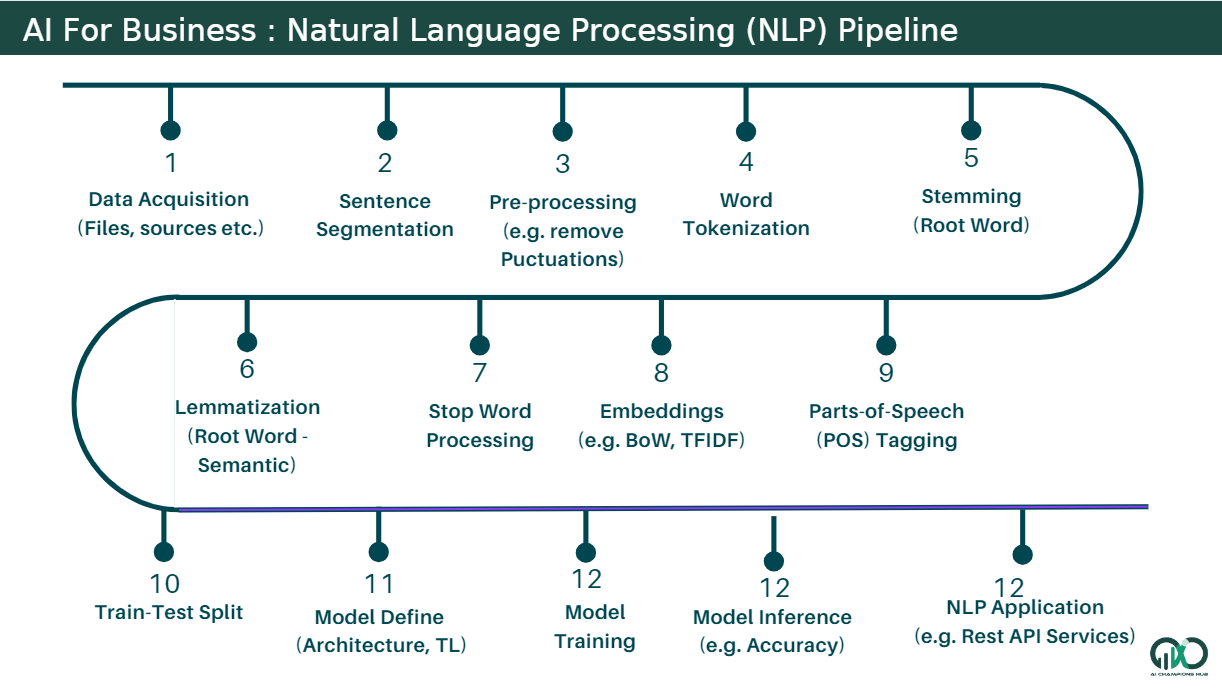

### S1B : Data Analysis

In [6]:
# !wget https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/download?datasetVersionNumber=4 as Tweets.csv
from google.colab import files
loaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [10]:
import io
df_clean_data = pd.read_csv(io.BytesIO(loaded['Tweets.csv']))
# Dataset is now stored in a Pandas Dataframe
df = df_clean_data.copy()

In [ ]:
# Note basic observations
print(df.shape)
df.info()
# Few observations : 14640 Tweets, includes both negative sentiment and positive reason. Text is key column
# Many values are nulls - negativereason (9178),

(14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  ob

In [ ]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

# S2 - Sentence Segmentation
Note in this case data is already split into individual like items or sentences

In [11]:
# keycols =['airline','text', 'tweet_id', 'airline_sentiment']
keycols =['airline','text', 'airline_sentiment', 'airline_sentiment_confidence']
df[keycols].head(5)

,airline,text,airline_sentiment,airline_sentiment_confidence
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative,1.0000


In [12]:
df['text'][1]  #Example read one tweet

"@VirginAmerica plus you've added commercials to the experience... tacky."

### S2A : Visualize Data

#### Plot Distribution of Sentiments **across all** Airlines

<Axes: xlabel='airline_sentiment', ylabel='count'>

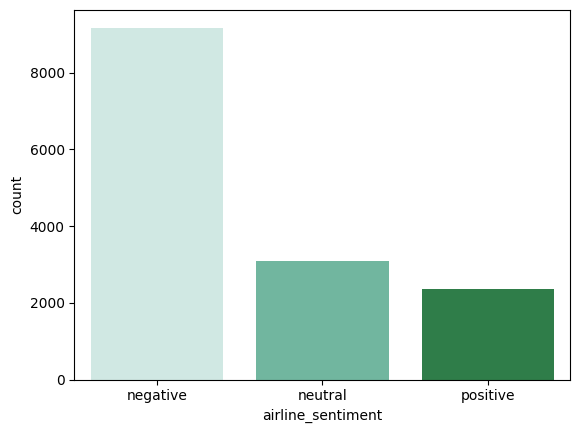

In [18]:
sns.countplot(x = "airline_sentiment", data = df, order =df.airline_sentiment.value_counts().index, palette='BuGn')

# Analysis: There very few Positive Sentiments and Mostly Negative Sentiments
# Implications: Data is not balanced - skewed towards negative sentiment

#### Distribution of Sentiments By Airlines

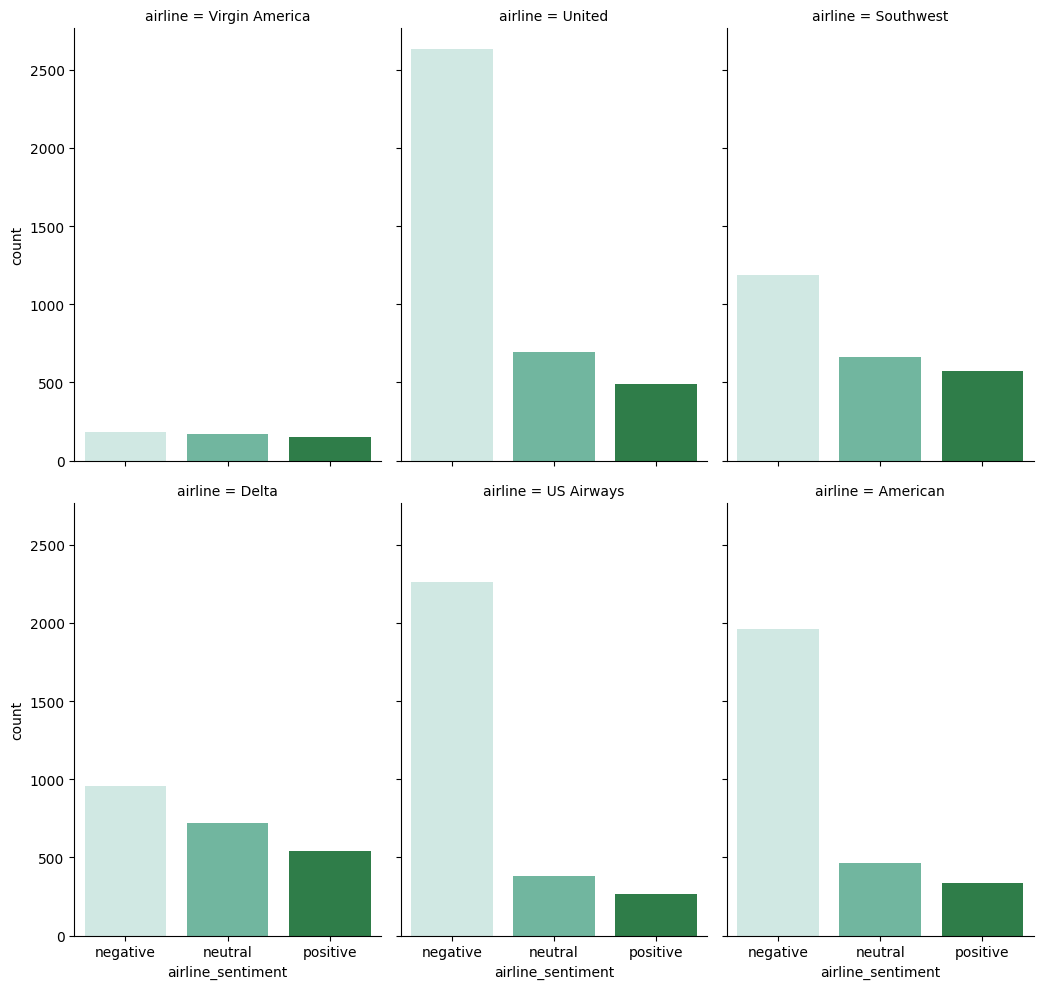

In [16]:
g = sns.FacetGrid(df, col='airline', col_wrap=3, height=5, aspect=0.7)
g = g.map(sns.countplot, "airline_sentiment",order =df.airline_sentiment.value_counts().index, palette='BuGn').add_legend()  # Accent
plt.show()

# Observations 1 : Airlines with most Negative Reviews - United, US_Airways, America, Southwest
# Observations 2 : Airlines with least Negative Reviews - Virgin America, Delta

#### Top Reasons for Negative Sentiments

In [19]:
y = df['negativereason'].value_counts()

<Axes: xlabel='negativereason', ylabel='count'>

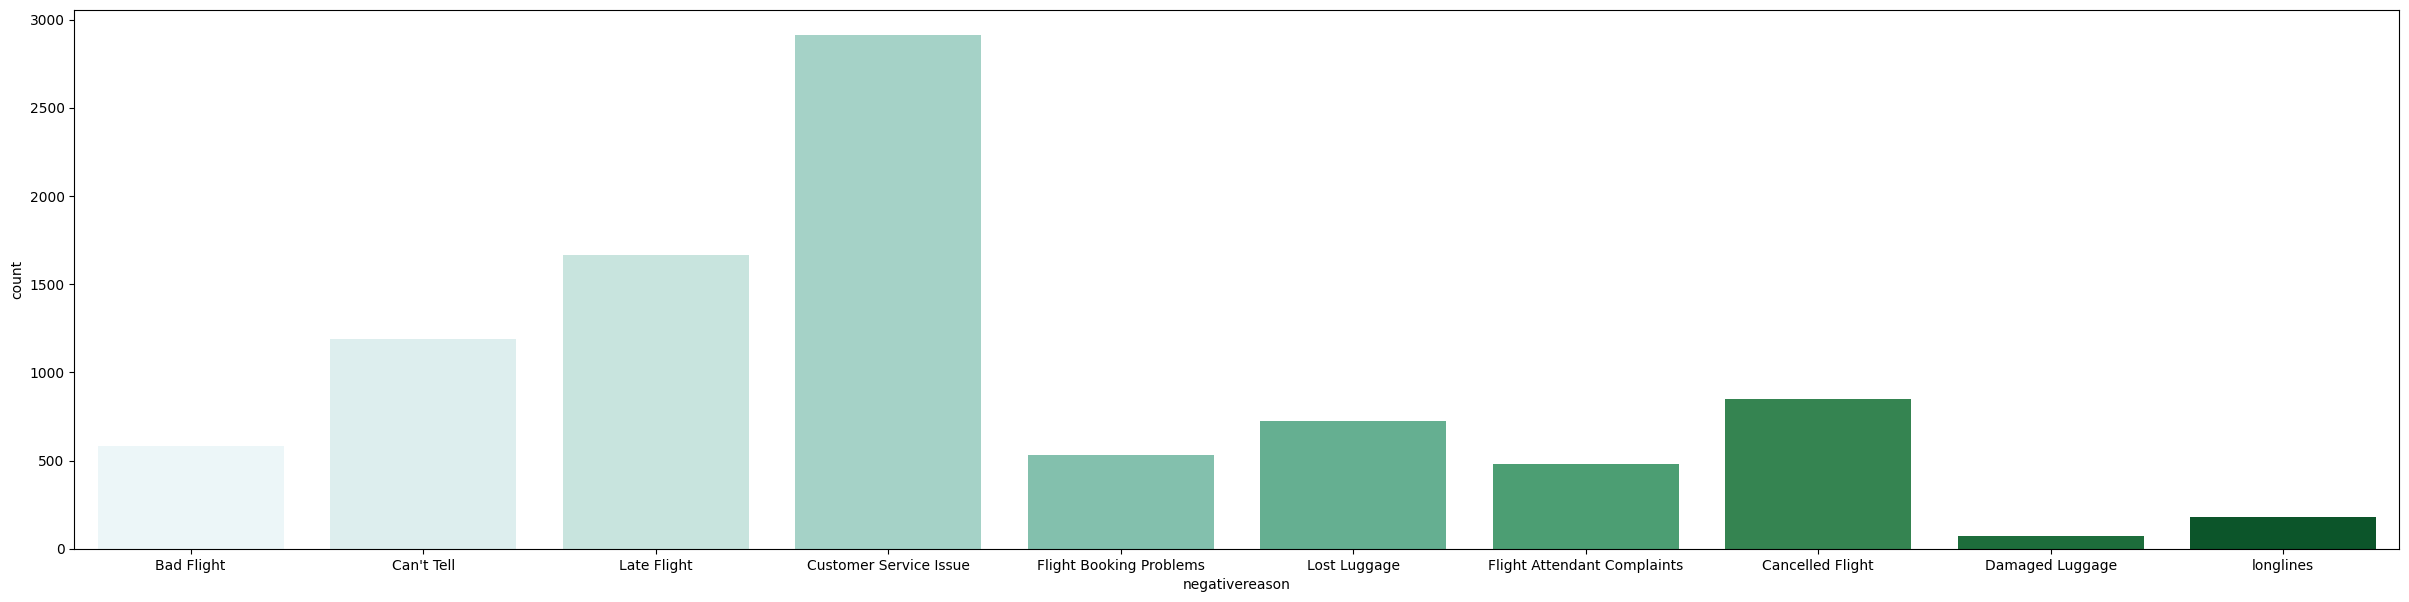

In [20]:
plt.figure(figsize=(30,7))
sns.countplot(x = "negativereason", data = df, palette='BuGn')  # Mostly Negative Sentitments

# S3 - Text Data Pre-Processing
Tweets have lot of characters or symbols etc. that may not be of value in final analysis. so need to process / cleanup data.

### S3AB : Data Preparation and Cleanup

#### Check for Duplicates and drop duplicate values

In [22]:
df_duplicates = df[df.duplicated()]
print(f"Count of Duplicate Rows : {df_duplicates.shape}\n")
print(df_duplicates[keycols].head(5))

# OBSERVATION  : There are few duplicates and we would like to drop the duplicates
df.drop_duplicates(keep=False,inplace=True)

Count of Duplicate Rows : (0, 15)

Empty DataFrame
Columns: [airline, text, airline_sentiment, airline_sentiment_confidence]
Index: []


#### Drop Columns that are not relevant like Tweet Id etc.

In [23]:
# Note we do keep a dataframe with full dataset in case required later.

cols_not_of_use_in_modeling = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline','airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created','tweet_location', 'user_timezone']
df = df.drop(cols_not_of_use_in_modeling, axis = 1)

In [27]:
print(df.shape)  # Note now we are left with main columns of interest
df.head(5)

(14568, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


### S3B : Tweets Deep Cleanup is important

Cleaning up is important in Twitter data since users include lot of characters or symbols etc..example Emojis, Symbols like # or @ etc.

In [28]:
# re : library for Regular Expressions based processing i.e. using Patterns to find components of a text and process
def fn_strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#### Function to Remove punctuations, links, mentions

In [30]:
# OPTIONAL TEST CODE TO ILLUSTRATE WORKING OF REGULAR EXPRESSION

# Note: We use Regular Expression to Process certain pattenrs like @ symbol
# This step is optional and included for elaboration
tags = r"@\w*"
sentence = "@VirginAmerica Sample@T Tweet @test"

# Syntax of sub function replaces one or many matches with a string in the given text
# re.sub(pattern, repl, string, count=0, flags=0)
# Pattern to be matched
# Repl : The value which has to be replaced in the string in place of matched pattern,
# string : the Target String to be replaced

sentence = [re.sub(tags, "", sentence)]
sentence

[' Sample Tweet ']

In [32]:
# Remove punctuations, links, mentions and \r\n new line characters

def fn_strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase

    # Note: We use Regular Expression to Process certain pattenrs like @ symbol
    # This step is optional and included for elaboration

    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#### Function to Clean Hashtags
Clean hastags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol


In [33]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol

def fn_clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#### Function to Filter special characters
Filter special characters such as & and $ present in some words

In [34]:
#Filter special characters such as & and $ present in some words

def fn_filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#### Function to Remove multiple spaces

In [35]:
def fn_remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

#### Perform all the cleanup

In [37]:
# Keep a copy of the text in column named 'text_original'.
# This is optional and done for learning to compare processed string with original

df['text_original'] = df['text']

In [38]:
df.head(5)

,airline_sentiment,text,text_original
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...


In [39]:
# Key Step to clean up text using the functions we wrote above for cleaning Tweets
# Note: The Functions are called one after the other - function chaining

texts_new = []
for t in df.text:
    texts_new.append(fn_remove_mult_spaces(fn_filter_chars(fn_clean_hashtags(fn_strip_all_entities(t)))))

df['text'] = texts_new        # Store the cleaned up text in the text column.

In [45]:
df.head(5)   # Observer the clean text and original text

,airline_sentiment,text,text_original
0,neutral,what said,@VirginAmerica What @dhepburn said.
1,positive,plus youve added commercials to the experience...,@VirginAmerica plus you've added commercials t...
2,neutral,i didnt today must mean i need to take another...,@VirginAmerica I didn't today... Must mean I n...
3,negative,its really aggressive to blast obnoxious enter...,@VirginAmerica it's really aggressive to blast...
4,negative,and its a really big bad thing about it,@VirginAmerica and it's a really big bad thing...


#  S4 : Word Tokenization and preparing for Text Data Representation

In [42]:
def fn_sentiment(x):
    if x == 'positive':
        return 1
    elif x == 'negative':
        return -1
    else:
        return 0

### S4A Remove Stop-Words
In English words like a, an, in, on, etc. are considered as stop-words. For our sentiment analysis we can remove as they don't have some specific meaning

In [44]:
from nltk.corpus import stopwords
nltk.download('stopwords')

STOPWORDS = stopwords.words('english')
print(f"\nExample list of Stopwords from NTLK Library {STOPWORDS[0:10]} \n")


Example list of Stopwords from NTLK Library ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"] 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def fn_remove_stopwords_lowercase(p_sentence):
    text = []
    for word in p_sentence:
        if word not in STOPWORDS:
            text.append(word.lower())
    return text;

In [47]:
ROWNUM = 16
print(f"Orignal Text : {df.text[ROWNUM]}")
print(f"\nPreprocessed Text : {fn_remove_stopwords_lowercase(df.text[ROWNUM])}")

Orignal Text : so excited for my first cross country flight lax to mco ive heard nothing but great things about virgin america 29daystogo

Preprocessed Text : [' ', 'e', 'x', 'c', 'e', ' ', 'f', 'r', ' ', ' ', 'f', 'r', ' ', 'c', 'r', ' ', 'c', 'u', 'n', 'r', ' ', 'f', 'l', 'g', 'h', ' ', 'l', 'x', ' ', ' ', 'c', ' ', 'v', 'e', ' ', 'h', 'e', 'r', ' ', 'n', 'h', 'n', 'g', ' ', 'b', 'u', ' ', 'g', 'r', 'e', ' ', 'h', 'n', 'g', ' ', 'b', 'u', ' ', 'v', 'r', 'g', 'n', ' ', 'e', 'r', 'c', ' ', '2', '9', 'g']


# S5 Perform Stemming
Stemming refers to removing suffixes and reducing a word to its basic form.
Example Test and Testing are both reduced to 'Test'.

Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

NOTE: I have include Stemming function for completness. But will be primarily using Lemmatizer as that may be good enough for the Sentiment Analysis example we are learning

https://stackoverflow.com/questions/17317418/stemmers-vs-lemmatizers

In [50]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('english')

nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [56]:
def fn_Stem(p_sentence):
    stemmer = SnowballStemmer('english')
    stems = []
    # print(p_sentence)
    for word in p_sentence:
        stem = stemmer.stem(word)
        stems.append(stem)
        #print(f"\nNext : {word, stems}")
    return stems;

In [57]:
ROWNUM = 22 # 24
sentence_sw = fn_remove_stopwords_lowercase(df.text[ROWNUM])
sentence_stemmed = fn_Stem(sentence_sw)

# S6 Perform Lemmatization
Lemmatization is used to get the original root word by using the Semantic meaning as opposed to just removing characters based on tenses etc.

## S5D Final function for data representation
This is the final main function that will be used for Text Data Representation. Usually we can perform stop-words processing, Stemming or lemmatization all in single function which is what is shown below.

In [48]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

tags = r"@\w*"         # There are many texts with @ symbol etc...need to remove these as well.
def fn_preprocess_text(p_sentence):

    p_sentence = [re.sub(tags, "", p_sentence)]
    text = []
    lemmatizer = WordNetLemmatizer()
    #stemmer = LancasterStemmer()

    # p_sentence_tokens = tokenizer.tokenize(p_sentence)
    for word in p_sentence:
        if word not in STOPWORDS:
           # print("\t WORD NOT STOPWORD")
           lemma = lemmatizer.lemmatize(word, pos='v').lower()
           text.append(lemma)
    return tokenizer.tokenize(" ".join(text))

In [60]:
SAMPLE = "@VirginAmerica This is a Sampling. Including a Sample Tweet here. Caring Care Car Walking Walk Walked Sample@T Tweet @test"
print(fn_preprocess_text(SAMPLE))
# print(fn_lemmatize_verbs(SAMPLE))

['this', 'is', 'a', 'sampling', 'including', 'a', 'sample', 'tweet', 'here', 'caring', 'care', 'car', 'walking', 'walk', 'walked', 'sample', 'tweet']


In [61]:
df['text_pre_representation'] = df['text']

In [62]:
df.text = df.text.map(fn_preprocess_text)

In [63]:
# Note 'text' should now have tokens after cleanup, removal of stopwords etc.
df[['airline_sentiment', 'text_original', 'text_pre_representation', 'text']].head()

,airline_sentiment,text_original,text_pre_representation,text
0,neutral,@VirginAmerica What @dhepburn said.,what said,"[what, said]"
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,"[plus, youve, added, commercials, to, the, exp..."
2,neutral,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,"[i, didnt, today, must, mean, i, need, to, tak..."
3,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,"[its, really, aggressive, to, blast, obnoxious..."
4,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,"[and, its, a, really, big, bad, thing, about, it]"


# S6 Embeddings
For our us to process and build models, we need text to represented in numeric form. There are various techniques to do so.

### Use SAMPLE TEXT FOR LEARNING

### S3A One-Hot Encoding
In One-Hot Encoding, each word is represented by an Id depending on Vocabulary being used. Let V be the size of the corpus vocabulary, then each word in our input is then represented by a V-dimensional binary vector of 0s and 1s.

### Not Implemented due to its disadvantages
Note : One-hot encoding is easy understand and implement. However, it has many disadvantages - like each word is given same importance, size is proportional to size of vocabulary, no meaning attached - to name a few.



### S3B Bag of Words (BoW)
Popular Technique where main idea is to represent the text under consideration as a bag (collection) of words while ignoring the order and context.

BoW also maps words to unique integer IDs between 1 and |V|.
Each document in the corpus is further  converted into a vector of |V| dimensions were in the ith component of the vector, i = wid, is simply the number of times the word w occurs in the document.

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

sample_bow = CountVectorizer()
sample_corpus = ["the bird flew", "the bird flew very high in the sky", "the bird with beautiful feathers"]

sample_bow.fit(sample_corpus)

test_text = ['the bird sat in the tree with other birds']
print(f"Vocabulary mapping based on sample : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence '")

print(sample_bow.transform(test_text).toarray())

Vocabulary mapping based on sample : 
 {'the': 7, 'bird': 1, 'flew': 3, 'very': 8, 'high': 4, 'in': 5, 'sky': 6, 'with': 9, 'beautiful': 0, 'feathers': 2}

Bag of word Representation of sentence '
[[0 1 0 0 0 1 0 2 0 1]]


#### Bag of words Use
BoW is also easy to understand and implement but it also has its disadvantages - size increases with Corpuse Vocabulary Size, Similar meaning words not captured to be same, handling of Out of Vocabulary Words is not automatic and order of words is lost.

### Bag of N-Grams
Instead of treating words seperately, Bag of N-Grams allows us to treat phrases or group of words together.
The corpus vocabulary, V, is then nothing but a collection of all unique n-grams across the text corpus.
Representation vector essentially contains the frequency counts of n-grams in the document. We use zero for the n-grams that are not present.

In [65]:
sample_BoNG = CountVectorizer(ngram_range = (2, 2))
sample_corpus = ["the bird flew", "the bird flew very high in the sky", "the bird with beautiful feathers"]

sample_BoNG.fit(sample_corpus)

test_text = ['the bird sat in the tree with other birds']

print(f"Vocabulary mapping based on sample : \n {sample_BoNG.vocabulary_}")
print("\nBag of word Representation of sentence '")

print(sample_BoNG.transform(test_text).toarray())

Vocabulary mapping based on sample : 
 {'the bird': 6, 'bird flew': 1, 'flew very': 3, 'very high': 8, 'high in': 4, 'in the': 5, 'the sky': 7, 'bird with': 2, 'with beautiful': 9, 'beautiful feathers': 0}

Bag of word Representation of sentence '
[[0 0 0 0 0 1 1 0 0 0]]


##### Bag of N-Grams Use
Advantage : Allows to capture some context and similarity. However dimensionality increases with increase in 'N' and the Out of Vocabulary handling is also a gap.

### TF-IDF : Term Frequency
- All the above mentioned methods don't allow for any ability to attach importance to words - all words treated equally.

Attaching Importance:
- If a word 'W' appears muliplte times in a Sentence 'Sx' but not in other Sentences in the Corpus then that word must be important to Sx.
- Importance increases based on Frequency of its occurance in Sentence Sx but Importance decreases in proportion to words frequency in other Sentences (Sn) of the document.
- Mathematically these are captured as TD and IDF. The combination is used to derive a TD-IDF Score.

**TERM FREQUENCY - TF (t,d) =  [Number of occurences of term t in document d] / [Total Number of terms in document d]**

**IDF INVERSE DOCUMENT FREQUENCY - IDF (t) =  LOG of ([Total number of Documents in the Corpus] / [Total Number of documents with terms t occuring in documents] )**

**TD-IDF Score is a Product of TF and IDF = TF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

sample_corpus = ["the bird flew", "the bird flew very high in the sky", "the bird with beautiful feathers"]
tfidf.fit_transform(sample_corpus)

print(f"IDF Values for sample corpus : {tfidf.idf_}")

test_text = ['the bird sat in the tree with other birds']

print("\nTFiDF Representation of sentence '")

print(tfidf.transform(test_text).toarray())

IDF Values for sample corpus : [1.69314718 1.         1.69314718 1.28768207 1.69314718 1.69314718
 1.69314718 1.         1.69314718 1.69314718]

TFiDF Representation of sentence '
[[0.         0.30523155 0.         0.         0.         0.51680194
  0.         0.61046311 0.         0.51680194]]


# S8 Embeddings

### WORD2VEC : Word 2 Vector based Word Embeddings


- They are vector representation of words that represent words with same meaning in similar manner.
- Word2Vec is a word embedding technique that uses Neural Network to learn word associations in input corpus.
- Mathematically these are captured as TD and IDF. The combination is used to derive a TD-IDF Score.
- Word2Vec project meaning of the words in a vector space such that words with similar meanings will tend to cluster. On the same token, words with different meanings are projected farther from each other.

NOTE: We don't need to train our own Word2Vec as that will be time consuming and expensive. So we will use Pre-trained Word2Vec models.
*   Word2vec by Google : One most common  implementations is with gensim. Disdvantage of Word2Vec is they rely only on local information of language.

*   GloVe by Stanford : GloVe does not rely just on local context information of words, but uses global statistics or word co-occurrence. So Glove can be used to find relations between words like synonyms, entity to product relations etc.

*   fasttext embeddings by Facebook


### APPROACH 1 - TFiDF Based Vectorization

In [66]:
# Initialize the "TfidfVectorizer" object to Convert a collection of raw documents to a matrix of TF-IDF features.

tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             min_df=5,
                             max_df=0.7,
                             ngram_range=(1,2))

# Note: The input to fit_transform should be a list of strings.
lst_clean_text = []
for word in df.text:
    lst_clean_text.append(" ".join(word))   #Note: this joins the tokens to form a sentence. We can use this to build vocabulary

print(type(lst_clean_text))
print(lst_clean_text[0:5])

<class 'list'>
['what said', 'plus youve added commercials to the experience tacky', 'i didnt today must mean i need to take another trip', 'its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse', 'and its a really big bad thing about it']


### Initial Model Buiding : Test with TFIDF
fit_transform() does two functions:
First it fits the model and learns the vocabulary;
Second it transforms our training data into feature vectors.


In [70]:
tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(lst_clean_text)
# print (tfidf_vectorizer_data_features)
tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()

print (tfidf_vectorizer_data_features.shape)
print(tfidf_vectorizer_data_features)

(14568, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [71]:
# Sample the words in the vocabulary
tfidf_vectorizer_vocab = tfidf_vectorizer.get_feature_names_out()
print(len(tfidf_vectorizer_vocab))
print (tfidf_vectorizer_vocab)

5000
['10' '10 hours' '10 hrs' ... 'yyz' 'zero' 'zone']


In [76]:
tfidf_vectorizer_stop_words = tfidf_vectorizer.get_stop_words()
print (tfidf_vectorizer_stop_words)

None


In [74]:
# Sum up the counts of each vocabulary word
tf_df_dist = np.sum(tfidf_vectorizer_data_features, axis=0)

# For each, print the vocabulary word and the number of times it
# appears in the training set
cnt=0
for tag, count in zip(tfidf_vectorizer_vocab, tf_df_dist):
    # print (tag, count)
    if cnt < 20:                        # Just Print first 20 Vocabulary items. Else we get a long list
       print (count, '\t', tag)
       cnt = cnt + 1

23.447539546835053 	 10
3.079062561157798 	 10 hours
2.4056239744347443 	 10 hrs
3.683660847215044 	 10 min
4.069686742595386 	 10 minutes
13.445622027552924 	 100
3.5178109386086143 	 1000
9.19635616088468 	 11
2.87781175422985 	 1130
19.61189150932459 	 12
6.090962302142026 	 12 hours
3.5206484055281138 	 12 hrs
5.442572634606434 	 13
3.8136881760173744 	 130
2.9015236515288723 	 136
3.80842232070695 	 14
4.213140345810883 	 140
22.1087486091979 	 15
6.388467660993922 	 15 hours
3.8766872058554807 	 15 hrs


### Fit and evaluate model using  tfidf vectorization.

<Axes: xlabel='airline_sentiment', ylabel='count'>

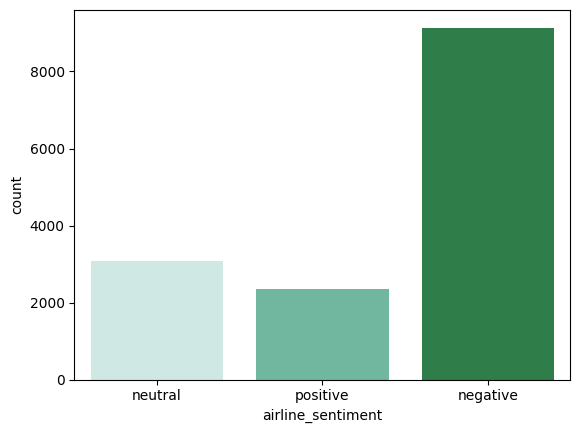

In [75]:
sns.countplot(x = "airline_sentiment", data = df, palette='BuGn')  # Mostly Negative Sentitments

# S10 - Split the data between Training and Testing

In [ ]:
# Split the data between Training and Testing
x_tf_idf = tfidf_vectorizer_data_features     # Predictor feature columns
y_tf_idf = df['airline_sentiment']   # Predicted class

x_train_tf_idf, x_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(x_tf_idf, y_tf_idf, test_size=0.3, random_state=32)

In [ ]:
print(len(tfidf_vectorizer_data_features))

14568

In [ ]:
print(x_train_tf_idf.shape, y_train_tf_idf.shape) #10197 Training rows,  4371 Testing rows
print(x_test_tf_idf.shape, y_test_tf_idf.shape)

(10197, 5000) (10197,)
(4371, 5000) (4371,)


### Balancing Classes as there are lot more negative sentiments than positive or neutral

In [ ]:
tf_idf_smt = SMOTE(random_state=0)
X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE = smt.fit_resample(x_train_tf_idf, y_train_tf_idf)

In [ ]:
print(X_train_tf_idf_SMOTE.shape)
print(y_train_tf_idf_SMOTE.shape)

(19017, 5000)
(19017,)


airline_sentiment
negative             6339
neutral              6339
positive             6339
dtype: int64


<Axes: xlabel='airline_sentiment', ylabel='count'>

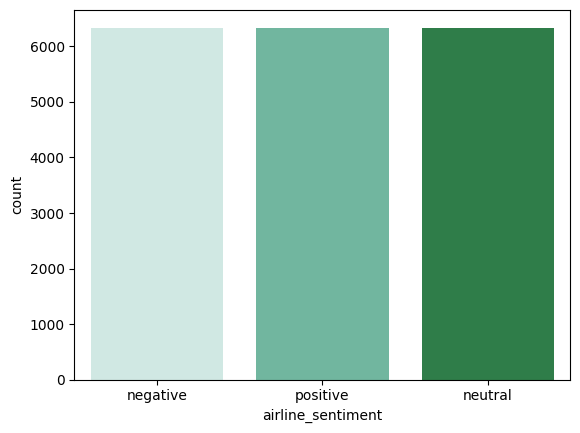

In [ ]:
df_y_train_tf_idf_SMOTE = pd.DataFrame(y_train_tf_idf_SMOTE, columns=['airline_sentiment'])
print(df_y_train_tf_idf_SMOTE.value_counts())
sns.countplot(x = "airline_sentiment", data = df_y_train_tf_idf_SMOTE, palette='BuGn')  # Mostly Negative Sentitments

# S11 Build a Classification Model : Try RandomForestClassifier

In [ ]:
# Initialize a Random Forest classifier with 100 trees

classifier_rf = RandomForestClassifier(verbose=1,n_jobs=-1,n_estimators = 100)

# Fit the forest to the training set
classifier_rf = classifier_rf.fit( X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.1s finished


In [ ]:
classifier_rf.score(X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


0.9961087448072777

#### Evaluate Score using Cross-Validation : Average across multiple samples

In [ ]:
print (np.mean(cross_val_score(classifier_rf, X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE,cv=10)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parall

0.8897881794462043


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


### Predict Sentiment based on the Trained Model or values

In [ ]:
# Dividing the test data into test and validation set in 50-50 ratio
x_validation_tf_idf, x_test_main_tf_idf, y_validation_tf_idf, y_test_main_tf_idf = train_test_split(x_test_tf_idf, y_test_tf_idf, test_size=0.50, random_state=1)

print(x_validation_tf_idf.shape)
print(x_test_main_tf_idf.shape)
print(y_validation_tf_idf.shape)
print(y_test_main_tf_idf.shape)

(2185, 5000)
(2186, 5000)
(2185,)
(2186,)


In [ ]:
y_validation_predict_tf_idf= classifier_rf.predict(x_validation_tf_idf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [ ]:
print("\n Training accuracy",classifier_rf.score(X_train_tf_idf_SMOTE,y_train_tf_idf_SMOTE))
print("\n Validation accuracy",classifier_rf.score(x_validation_tf_idf, y_validation_tf_idf))
print(" ")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



 Training accuracy 0.9961087448072777

 Validation accuracy 0.7693363844393593
 


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
print(metrics.classification_report(y_validation_tf_idf,y_validation_predict_tf_idf))

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85      1384
     neutral       0.61      0.53      0.57       441
    positive       0.74      0.58      0.65       360

    accuracy                           0.77      2185
   macro avg       0.72      0.67      0.69      2185
weighted avg       0.76      0.77      0.76      2185



# Print the Confusion Matrix

<Figure size 640x480 with 0 Axes>

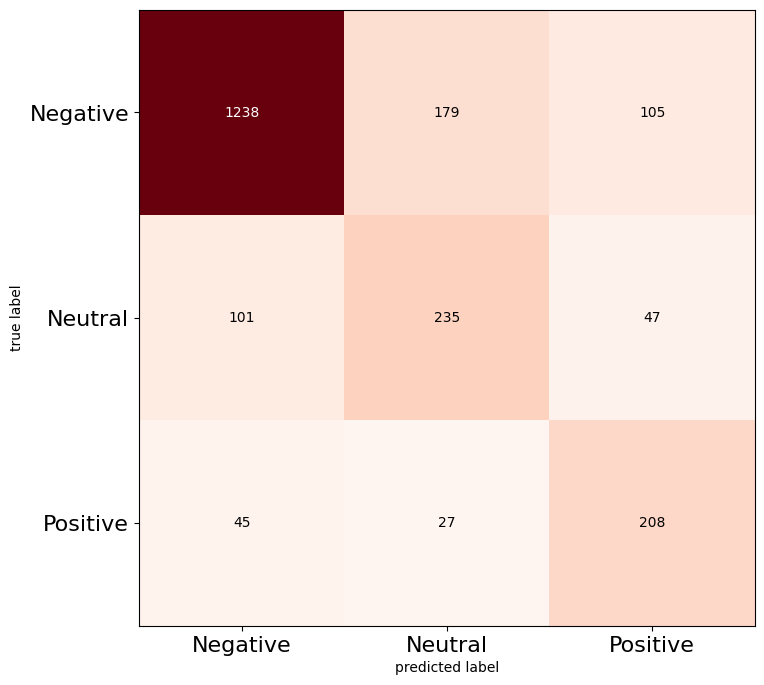

In [ ]:
cm=confusion_matrix(y_validation_predict_tf_idf , y_validation_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

In [ ]:
print("Test accuracy",classifier_rf.score(x_test_main_tf_idf, y_test_main_tf_idf))
print()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


Test accuracy 0.7634949679780421



# Make Class Predictions on Test Data

In [ ]:
# Make class predictions for the test set
y_test_predict_tf_idf= classifier_rf.predict(x_test_main_tf_idf)
print(metrics.classification_report(y_test_main_tf_idf,y_test_predict_tf_idf))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      1417
     neutral       0.59      0.46      0.52       439
    positive       0.71      0.57      0.63       330

    accuracy                           0.76      2186
   macro avg       0.70      0.64      0.67      2186
weighted avg       0.75      0.76      0.75      2186



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


### Print Confusion Matrix on Test Data Output

<Figure size 640x480 with 0 Axes>

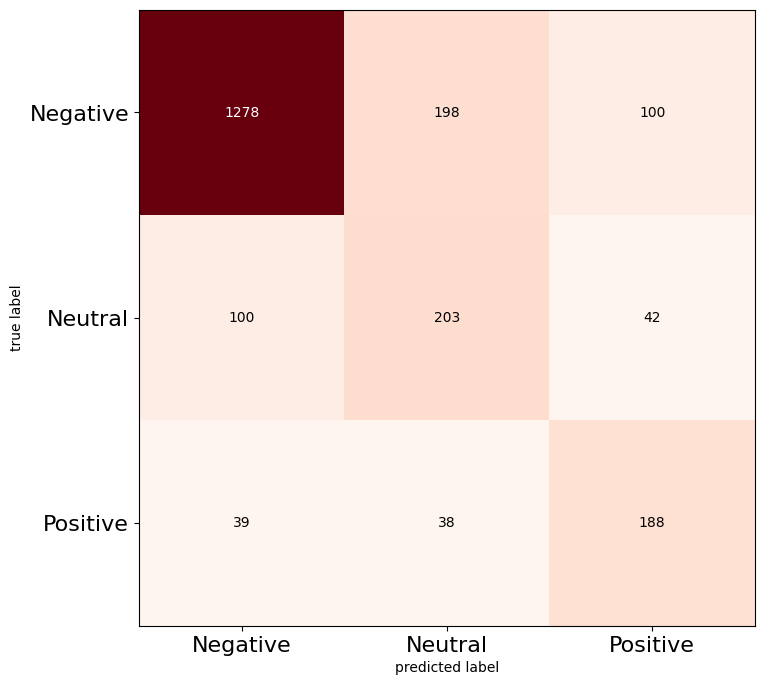

In [ ]:
cm=confusion_matrix(y_test_predict_tf_idf , y_test_main_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

# Performance of Classification Model and Summary

Performance based on RandomForestClassifier on TfidfVectorizer

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training accuracy 0.9961087448072777



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Test accuracy 0.7634949679780421



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      1417
     neutral       0.59      0.46      0.52       439
    positive       0.71      0.57      0.63       330

    accuracy                           0.76      2186
   macro avg       0.70      0.64      0.67      2186
weighted avg       0.75      0.76      0.75      2186



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


<Figure size 640x480 with 0 Axes>

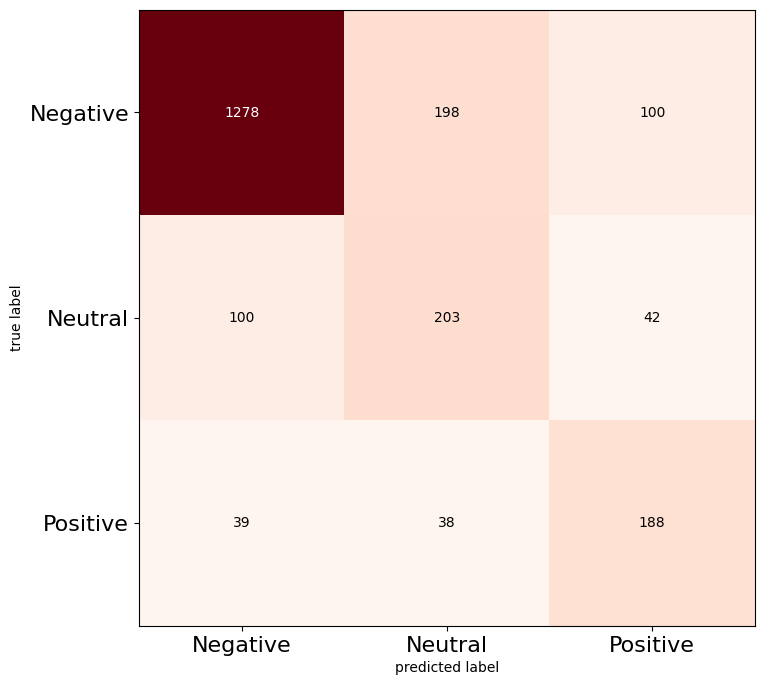

In [ ]:
print("Training accuracy",classifier_rf.score(X_train_tf_idf_SMOTE,y_train_tf_idf_SMOTE))
print()
print("Test accuracy",classifier_rf.score(x_test_main_tf_idf, y_test_main_tf_idf))
print()

# Make class predictions for the test set
y_test_predict_tf_idf= classifier_rf.predict(x_test_main_tf_idf)
print(metrics.classification_report(y_test_main_tf_idf,y_test_predict_tf_idf))

cm=confusion_matrix(y_test_predict_tf_idf , y_test_main_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

In [ ]:
Accuracy=[]
Model=[]
Accuracy.append(classifier_rf.score(x_test_main_tf_idf, y_test_main_tf_idf))
Model.append("RandomForestClassifier on TfidfVectorizer")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


# Conclusions or Final Observations

RandomForestClassifier on TfidfVectorizer has an accuracy of 77% whereas RandomForestClassifier on CountVectorizer has an accuracy of 75%. This shows that the model using TfidfVectorizer is better.
Model is able to predict airline sentiment correctly 77% of the time

1.   RandomForestClassifier on TfidVectorizer has accuracy of 77%
2.   Model is able to predict Airline Sentiment correctly 77% of the time

